<a href="https://colab.research.google.com/github/le-pigeon/fantastic-winner/blob/main/Testing_deep_unrolled_algo_simulated_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab test

In [1]:
# ✅ Step 1: Mount Google Drive
from google.colab import drive
import zipfile
import os

# drive.mount('/content/drive')  # Connect to your Google Drive

# ✅ Step 2: Define Paths
#zip_path = "/content/drive/MyDrive/SAR_Project/Dataset/UCMerced_LandUse.zip"  # Adjust path if needed
# extract_path = "/content/test_data/UCMerced_SAR_Dataset"  # Where to extract
zip_path = "/content/drive/MyDrive/SAR_Project/Dataset/SAR-despeckle-Dataset.zip"
extract_path = "/content/test_data/SAR_Dataset"  # Where to extract


# ✅ Step 3: Extract ZIP
print("🔥 Extracting dataset... this may take a moment!")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete!")

# ✅ Step 4: Verify Files
print("📂 Checking extracted files...")
print(os.listdir(extract_path)[:10])  # Show first 10 files/folders

🔥 Extracting dataset... this may take a moment!
✅ Extraction complete!
📂 Checking extracted files...
['SAR-despeckle-Dataset']


In [2]:
# Colab-ready PyTorch Implementation of SAR-DURNet (Deep Unrolling for SAR Despeckling)
# This script trains a deep unrolling network for SAR despeckling.
# Steps:
# 0. Pay for premium GPU :)
# 1. Set up dataset (simulated speckle noise on optical images)
# 2. Define SAR-DURNet model
# 3. Train with Charbonnier + Total Variation loss
# 4. Test on real SAR images


import glob
import cv2
import numpy as np
import torch
import torch.nn as nn  # ✅ Add this!
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import random


# Automatically select CPU if no GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

🔥 Using device: cuda


In [3]:
# Deal with data set that I have
class UCSARImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, L=1, img_size=(256, 256)):
        """Loads all images from multiple subfolders, converts to grayscale, and resizes them."""
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**/*.tif"), recursive=True))
        if len(self.image_paths) == 0:
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**/*.png"), recursive=True))
        if len(self.image_paths) == 0:
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**/*.jpg"), recursive=True))
        if len(self.image_paths) == 0:
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**/*.bmp"), recursive=True))  # 🔥 Added BMP support!
        self.transform = transform
        self.L = L  # Number of looks for speckle simulation
        self.img_size = img_size  # Set target size for all images

    def add_speckle_noise(self, image):
        """Adds SAR-like speckle noise using a Gamma distribution."""
        noise = np.random.gamma(self.L, 1.0 / self.L, image.shape).astype(np.float32)
        noise = np.clip(noise, 1e-6, None)  # ✅ Avoid zero values
        speckled = image * noise
        return np.clip(speckled, 0, 1).astype(np.float32)


    def add_frequency_based_speckle(image, min_L=1, max_L=5, cutoff=0.2):
      """Adds SAR speckle noise with controlled size using frequency filtering."""
      L = np.random.randint(min_L, max_L + 1)
      noise = np.random.gamma(L, 1.0 / L, image.shape)

      # Convert to frequency domain
      noise_fft = np.fft.fft2(noise)
      h, w = noise.shape
      mask = np.zeros((h, w), np.float32)
      mask[int(h*cutoff):int(h*(1-cutoff)), int(w*cutoff):int(w*(1-cutoff))] = 1  # 🔥 Keep low frequencies

      # Apply frequency mask to control speckle size
      noise_filtered = np.fft.ifft2(noise_fft * mask).real
      speckled = image * noise_filtered

      return np.clip(speckled, 0, 1)


    def add_randomized_speckle_noise(image):
      """Adds SAR-like speckle noise with random noise grain size."""
      methods = [add_scaled_speckle_noise, add_frequency_based_speckle]
      method = random.choice(methods)  # 🔥 Randomly pick a noise model
      return method(image)


    def add_scaled_speckle_noise(image, min_L=1, max_L=5, kernel_size=5):
      """Adds SAR-like speckle noise with variable size using Gaussian blur."""
      L = np.random.randint(min_L, max_L + 1)  # 🔥 Random number of looks
      noise = np.random.gamma(L, 1.0 / L, image.shape)

      if kernel_size > 1:  # 🔥 Adjust noise grain size
          noise = cv2.GaussianBlur(noise, (kernel_size, kernel_size), 0)

      speckled = image * noise
      return np.clip(speckled, 0, 1)

    def __getitem__(self, index):
        img = cv2.imread(self.image_paths[index], cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img = cv2.resize(img, self.img_size) / 255.0

        speckled = self.add_speckle_noise(img)
        speckled = cv2.resize(speckled, self.img_size)

        if self.transform:
            img = self.transform(img)  # ❌ Remove .unsqueeze(0) here!
            speckled = self.transform(speckled)  # ❌ Remove .unsqueeze(0) here!

        return speckled.float(), img.float()  # ✅ Now it's (C, H, W), not (1, 1, H, W)

    def __len__(self):
        return len(self.image_paths)


# Define Transformations & Load Dataset
transform = transforms.Compose([transforms.ToTensor()])
# dataset_path = "/content/test_data/UCMerced_SAR_Dataset/UCMerced_LandUse/Images"
dataset_path = "/content/test_data/SAR_Dataset/SAR-despeckle-Dataset"
train_dataset = UCSARImageDataset(dataset_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

print(f"Loaded {len(train_dataset)} images from UC Merced dataset!")





Loaded 1872 images from UC Merced dataset!


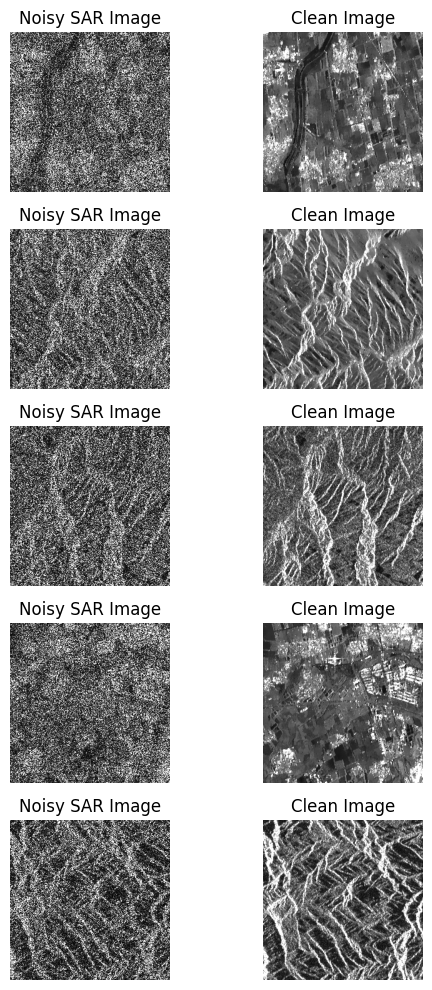

In [4]:
import matplotlib.pyplot as plt
import random

# Function to show images
def show_random_images(dataset, num_images=5):
    indices = random.sample(range(len(dataset)), num_images)  # Pick random indices
    fig, axes = plt.subplots(num_images, 2, figsize=(6, num_images * 2))

    for i, idx in enumerate(indices):
        noisy, clean = dataset[idx]  # Load a random (Noisy, Clean) image pair
        noisy, clean = noisy.squeeze().numpy(), clean.squeeze().numpy()  # Convert tensors to numpy

        axes[i, 0].imshow(noisy, cmap='gray')
        axes[i, 0].set_title("Noisy SAR Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(clean, cmap='gray')
        axes[i, 1].set_title("Clean Image")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# ✅ Show 10 random images from the dataset
show_random_images(train_dataset)

In [6]:
for batch_idx, (noisy, clean) in enumerate(train_loader):
    if noisy.max() == 0 or clean.max() == 0:
        print(f"❌ WARNING: Pure black image found in Batch {batch_idx}")


In [5]:
# 🔥 Simple Residual U-Net (ResUNet) for SAR despeckling
class ResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256]):
        super(ResUNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 🔥 Encoder (Downsampling with residual connections)
        for feature in features:
            self.encoder.append(self.conv_block(in_channels, feature))
            in_channels = feature

        # 🔥 Bottleneck (Middle layer)
        self.bottleneck = self.conv_block(features[-1], features[-1] * 2)

        # 🔥 Decoder (Upsampling with skip connections)
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self.conv_block(feature * 2, feature))

        # 🔥 Final output layer
        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Residual convolutional block"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        skip_connections = []

        # 🔥 Encoder pass
        for enc in self.encoder:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)

        # 🔥 Bottleneck
        x = self.bottleneck(x)

        # 🔥 Decoder pass with skip connections
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)

        return self.final_layer(x)  # 🔥 Output despeckled image

In [6]:
test_input = torch.randn(1, 1, 256, 256)  # Simulated SAR patch
model = ResUNet()
output = model(test_input)

print("🔥 ResUNet Output Shape:", output.shape)  # ✅ Should match (1, 1, 256, 256)


🔥 ResUNet Output Shape: torch.Size([1, 1, 256, 256])


In [10]:
# ========== 2. SAR-DURNet: Deep Unrolling Model ==========
class SAR_DURNet(nn.Module):
        def __init__(self, num_layers=6):
            super(SAR_DURNet, self).__init__()
            self.num_layers = num_layers
            self.resunet = ResUNet()  # 🔥 Use U-Net for feature extraction

            # ✅ DEFINE gradient_steps so it's not missing!
            self.gradient_steps = nn.ModuleList([nn.Conv2d(1, 1, kernel_size=3, padding=1) for _ in range(num_layers)])

        def forward(self, x):
            v = x
            for i in range(self.num_layers):
                noise_est = self.resunet(v)
                x = x - 0.1 * self.gradient_steps[i](noise_est)
                v = F.leaky_relu(x, negative_slope=0.01)  # 🔥 Fix ReLU issue

            return x - self.resunet(v)  # 🔥 Output despeckled image

model = SAR_DURNet().to(device)  # Move model to CPU or GPU

# ========== 3. Loss Function & Optimizer ==========
def charbonnier_loss(x, y, epsilon=1e-6):  # 🔥 Increase epsilon to prevent division issues
    diff = x - y
    return torch.mean(torch.sqrt(diff ** 2 + epsilon ** 2))

def total_variation_loss(img, epsilon=1e-6):
    """Fixes NaN issues by ensuring TV loss never divides by zero."""
    diff1 = img[:, :, :-1] - img[:, :, 1:]  # Horizontal diff
    diff2 = img[:, :-1, :] - img[:, 1:, :]  # Vertical diff

    # ✅ Prevent NaNs by adding epsilon before mean calculation
    tv_loss = torch.mean(torch.sqrt(diff1 ** 2 + epsilon)) + torch.mean(torch.sqrt(diff2 ** 2 + epsilon))

    if torch.isnan(tv_loss):
        print("❌ TV Loss STILL caused NaN after fix!")

    return tv_loss


def edge_preserving_loss(output, clean, alpha=0.01):
    edges_output = torch.abs(output[:, :, :-1] - output[:, :, 1:])  # Horizontal edges
    edges_clean = torch.abs(clean[:, :, :-1] - clean[:, :, 1:])  # Ground truth edges
    return alpha * torch.mean(torch.abs(edges_output - edges_clean))  # Edge difference loss


optimizer = optim.Adam(model.parameters(), lr=0.00001)

num_epochs = 15  # Set the number of epochs (adjust as needed)

# ========== 4. Training Loop ==========
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (noisy, clean) in enumerate(train_loader):
        noisy, clean = noisy.to(device), clean.to(device)

        optimizer.zero_grad()
        output = model(noisy)

        # ✅ Print output values before computing loss
        # print(f"   🔹 Output min: {output.min().item()}, max: {output.max().item()}")

        loss = charbonnier_loss(output, clean) + edge_preserving_loss(output, clean, alpha=0.01)

        # ✅ Check if loss is NaN BEFORE backprop
        if torch.isnan(loss):
            print(f"❌ NaN loss detected at Epoch {epoch+1}, Batch {batch_idx}, Loss BEFORE backprop: {loss.item()}")
            continue  # Skip this batch

        # print(f"✅ Loss BEFORE backprop: {loss.item()}")  # 🔥 If this prints NaN, loss function is broken!

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # ✅ Clip gradients
        optimizer.step()

        total_loss += loss.item()

    print(f"✅ Epoch {epoch+1} | Avg Loss: {total_loss/len(train_loader):.4f}")

# ========== 5. Save Model ==========
os.makedirs("/content/model", exist_ok=True)  # ✅ Create folder if it doesn't exist
torch.save(model.state_dict(), "/content/model/sar_durnet.pth")
print("Model saved!")

✅ Epoch 1 | Avg Loss: 0.2507
✅ Epoch 2 | Avg Loss: 0.1396
✅ Epoch 3 | Avg Loss: 0.1256
✅ Epoch 4 | Avg Loss: 0.1208
✅ Epoch 5 | Avg Loss: 0.1181
✅ Epoch 6 | Avg Loss: 0.1162
✅ Epoch 7 | Avg Loss: 0.1146
✅ Epoch 8 | Avg Loss: 0.1135
✅ Epoch 9 | Avg Loss: 0.1124
✅ Epoch 10 | Avg Loss: 0.1116
✅ Epoch 11 | Avg Loss: 0.1109
✅ Epoch 12 | Avg Loss: 0.1104
✅ Epoch 13 | Avg Loss: 0.1098
✅ Epoch 14 | Avg Loss: 0.1093
✅ Epoch 15 | Avg Loss: 0.1090
Model saved!


Took about 22min for 20 epochs last time

* ✅ Epoch 1 | Avg Loss: 0.2307
* ✅ Epoch 2 | Avg Loss: 0.1420
* ✅ Epoch 3 | Avg Loss: 0.1268
* ✅ Epoch 4 | Avg Loss: 0.1215
* ✅ Epoch 5 | Avg Loss: 0.1184
* ✅ Epoch 6 | Avg Loss: 0.1162
* ✅ Epoch 7 | Avg Loss: 0.1146
* ✅ Epoch 8 | Avg Loss: 0.1133
* ✅ Epoch 9 | Avg Loss: 0.1123
* ✅ Epoch 10 | Avg Loss: 0.1115
* ✅ Epoch 11 | Avg Loss: 0.1108
* ✅ Epoch 12 | Avg Loss: 0.1102
* ✅ Epoch 13 | Avg Loss: 0.1098
* ✅ Epoch 14 | Avg Loss: 0.1092
* ✅ Epoch 15 | Avg Loss: 0.1089 --> can stop here maybe?
* ✅ Epoch 16 | Avg Loss: 0.1085
* ✅ Epoch 17 | Avg Loss: 0.1081
* ✅ Epoch 18 | Avg Loss: 0.1078
* ✅ Epoch 19 | Avg Loss: 0.1076
* ✅ Epoch 20 | Avg Loss: 0.1073
* ✅ Epoch 21 | Avg Loss: 0.1070
* ✅ Epoch 22 | Avg Loss: 0.1068
* ✅ Epoch 23 | Avg Loss: 0.1067
* ✅ Epoch 24 | Avg Loss: 0.1065
* ✅ Epoch 25 | Avg Loss: 0.1063
* ✅ Epoch 26 | Avg Loss: 0.1061
* ✅ Epoch 27 | Avg Loss: 0.1060
* ✅ Epoch 28 | Avg Loss: 0.1059
* ✅ Epoch 29 | Avg Loss: 0.1057
* ✅ Epoch 30 | Avg Loss: 0.1056





🔥 Processing /content/imported_images/SG_PasirPanjang_2025-02-10-00_00_2025-02-10-23_59_Sentinel-1_IW_VV+VH_VH_-_decibel_gamma0.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_SG_PasirPanjang_2025-02-10-00_00_2025-02-10-23_59_Sentinel-1_IW_VV+VH_VH_-_decibel_gamma0.jpg


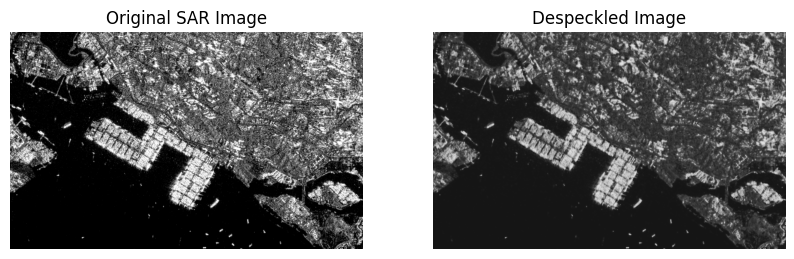

🔥 Processing /content/imported_images/SG_port.tiff...
✅ Saved despeckled image to /content/despeckled_results/despeckled_SG_port.tiff


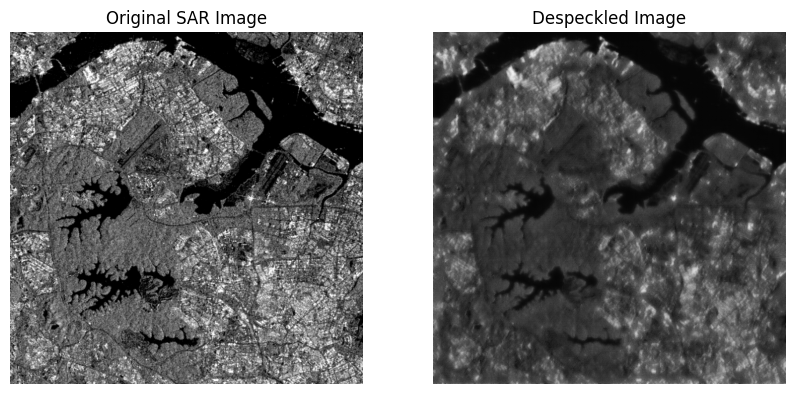

🔥 Processing /content/imported_images/bali_mt.tiff...
✅ Saved despeckled image to /content/despeckled_results/despeckled_bali_mt.tiff


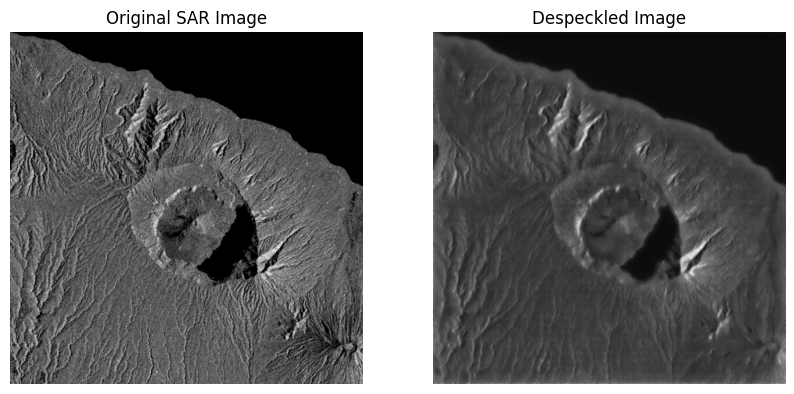

🔥 Processing /content/imported_images/chicago.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_chicago.jpg


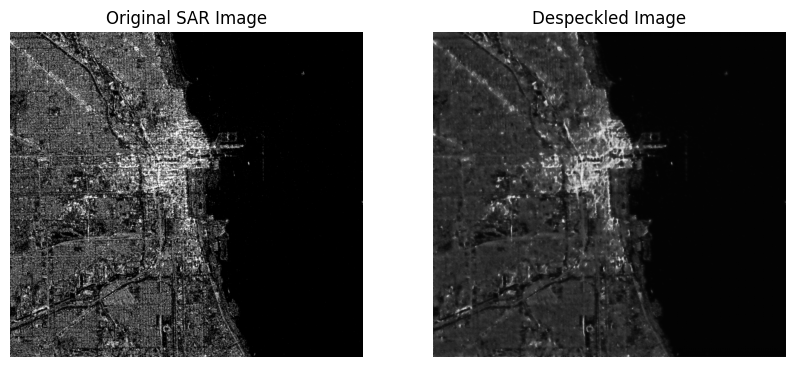

🔥 Processing /content/imported_images/hokkaido_summer.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_hokkaido_summer.jpg


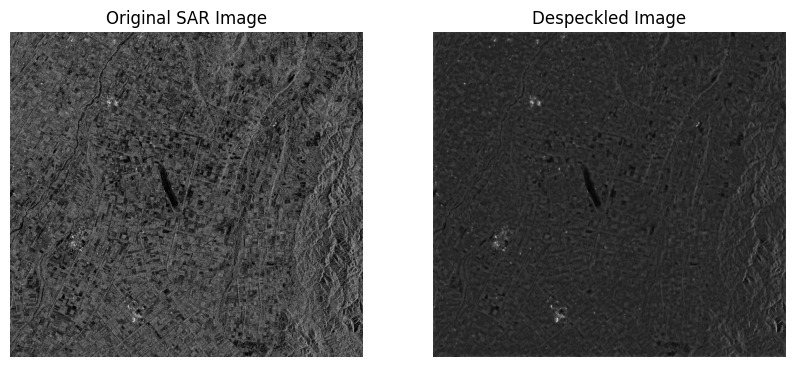

🔥 Processing /content/imported_images/hokkaido_winter.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_hokkaido_winter.jpg


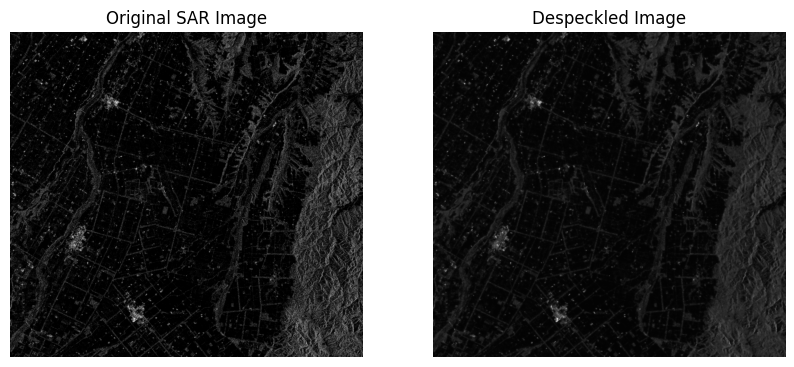

🔥 Processing /content/imported_images/kyoto.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_kyoto.jpg


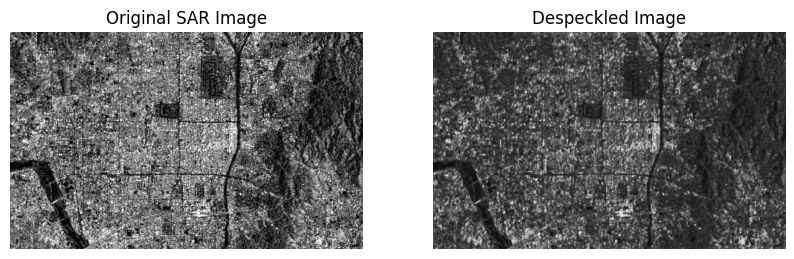

🔥 ALL IMAGES PROCESSED SUCCESSFULLY!


In [11]:
import glob
import cv2
import torch
import os
import matplotlib.pyplot as plt

# ✅ Define paths
input_folder = "/content/imported_images/"  # 🔥 Change this to your SAR image folder
output_folder = "/content/despeckled_results/"  # 🔥 Where despeckled images will be saved

# ✅ Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# ✅ Load model in eval mode
model.eval()

# ✅ Find all SAR images in the folder
valid_extensions = ["tiff", "tif", "png", "jpg", "bmp"]
image_paths = sorted(
    [img for ext in valid_extensions for img in glob.glob(os.path.join(input_folder, f"*.{ext}"))]
)
  # 🔥 Change extension if needed

# ✅ Function to resize image to multiple of 32
def resize_to_multiple_of_32(image):
    """Resizes image to the nearest lower multiple of 32 for U-Net compatibility."""
    h, w = image.shape
    new_h = (h // 32) * 32  # Round down to nearest multiple of 32
    new_w = (w // 32) * 32
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

# ✅ Process each image
for img_path in image_paths:
    print(f"🔥 Processing {img_path}...")

    # Load image
    test_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if test_image is None:
        print(f"❌ Skipping {img_path}, could not load image!")
        continue

    # Normalize & Resize
    test_image = test_image / 255.0  # Normalize to [0,1]
    test_image_resized = resize_to_multiple_of_32(test_image)

    # Convert to PyTorch tensor
    test_tensor = torch.tensor(test_image_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # ✅ Run through model
    with torch.no_grad():
        despeckled_image = model(test_tensor).squeeze().cpu().numpy()

    # 🔥 Save the despeckled image
    output_filename = "despeckled_" + os.path.basename(img_path)
    output_path = os.path.join(output_folder, output_filename)
    cv2.imwrite(output_path, (despeckled_image * 255).astype(np.uint8))  # Convert back to [0,255]

    print(f"✅ Saved despeckled image to {output_path}")

    # 🔥 Show Before & After
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image_resized, cmap="gray")
    plt.title("Original SAR Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(despeckled_image, cmap="gray")
    plt.title("Despeckled Image")
    plt.axis("off")

    plt.show()  # ✅ Display the images

print("🔥 ALL IMAGES PROCESSED SUCCESSFULLY!")
